In [1]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
import json
import logging
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy import spatial
from sklearn.manifold import TSNE
from ngly1_gpt import utils, llm
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', 250)

In [2]:
with open(utils.get_paths().resources / "evidence" / "diseases.yaml", 'r') as f:
    diseases = yaml.safe_load(f)
diseases[1]

{'label': 'Blau Syndrome',
 'mondo_url': 'https://monarchinitiative.org/disease/MONDO:0008523',
 'mondo_id': 'MONDO:0008523',
 'evidence': {'omim': "Molecular Genetics\nBecause mutations in the NOD2/CARD15 gene had been found in Crohn disease (266600), a disorder characterized by episodic intestinal inflammation with epithelioid granulomas, and because CARD15 is expressed predominantly in monocytes, a cell type that can differentiate into giant and epithelioid cells aggregating in granuloma formations, Miceli-Richard et al. (2001) did a mutation screen of 4 families with Blau syndrome and identified 3 different missense mutations in the CARD15 gene (605956.0004-605956.0006). One of the families had been reported by Manouvrier-Hanu et al. (1998). In a 27-year-old Japanese man with systemic granulomatous disease, in whom lack of a family history of the disease led to a diagnosis of 'early-onset sarcoidosis' rather than Blau syndrome, Kanazawa et al. (2004) identified 1 of the same CARD15

In [3]:
import pickle
with open(utils.get_paths().output_data / "disease_maps.pkl", 'rb') as f:
    disease_map_spec = pickle.load(f)

In [4]:
disease_map_spec[1]

{'disease': {'label': 'Rheumatoid Arthritis',
  'mondo_url': 'https://monarchinitiative.org/disease/MONDO:0008383',
  'mondo_id': 'MONDO:0008383',
  'evidence': {'omim': 'Pathogenesis\nUpregulation of proinflammatory cytokines in RA synovium and synovial fluid is a feature of active disease and intense inflammation. Antiinflammatory mediators are also present and activated in RA but fail to counterregulate the proinflammatory cytokines. Muller-Ladner et al. (2000) found that the IL4-STAT (STAT6; 601512) pathway is activated in patients with short-term (less than 1 year) and long-term (more than 2 years) RA and may contribute to downregulation of the immunologic activity in RA synovium. \n\nIn a T-cell receptor transgenic mouse model, an inflammatory arthritis that resembles human RA is initiated by T cells but is sustained by antibodies to GPI (172400). Using ELISA analysis, Schaller et al. (2001) detected high levels of antibody to GPI, independent of the presence of rheumatoid factor

In [5]:
diseases[3]

{'label': 'Familial Mediterranean fever',
 'mondo_url': 'https://monarchinitiative.org/disease/MONDO:0018088',
 'mondo_id': 'MONDO:0018088',
 'omim_url': 'https://omim.org/entry/249100',
 'evidence': {'omim': 'Pathogenesis\nBabior and Matzner (1997) suggested that the pathogenesis of FMF is as follows: pyrin, or marenostrin, is postulated to activate the biosynthesis of a chemotactic factor inactivator, an enzyme that normally occurs in the serosal fluids. They suggested that a chemotactic factor (probably C5a; 113995) can be released by subclinical injury to the serosa during normal activities, but the amounts released are small enough that they are cleared by the inactivating enzyme before they can provoke an inflammatory reaction. In FMF the inactivating enzyme is absent, allowing the chemotactic factors to survive long enough to call in neutrophils, which then release a variety of products, including an enzyme that generates more C5a. The result is an upward spiral that culminates 

In [6]:

def convert_graph_json(graph_json: str, disease: str, segment: str) -> nx.MultiDiGraph:
    G = nx.node_link_graph(json.loads(graph_json), directed=True, multigraph=True)

    G = nx.relabel_nodes(G, {node: G.nodes[node]['label'] for node in G.nodes()})

    primary_node = None
    for node in G.nodes():
        if G.nodes[node]["label"].lower() == disease.lower():
            primary_node = node

    if primary_node is None:
        primary_node = disease
        G.add_node(primary_node, label=disease, type="Disease")

    for node in list(G.nodes()):
        if G.in_degree(node) == 0 and node != primary_node:
            if not G.has_edge(primary_node, node) and not G.has_edge(
                node, primary_node
            ):
                G.add_edge(primary_node, node, type="associated with")
    return G

def get_disease_graph(disease, specs):
    parts = []
    for spec in specs:
        if spec["disease"]["mondo_id"] == disease["mondo_id"]:
            parts.append(spec)
    if not parts:
        raise ValueError(f"Could not find disease map for {disease['label']} - {disease['mondo_id']}")
    graphs = []
    for i, spec in enumerate(parts):
        graphs.append(convert_graph_json(spec["graph_json"], disease=disease["label"], segment=f"{i}-{spec['chunk_index']}"))
    #return nx.union_all(graphs)
    return nx.compose_all(graphs)

disease_maps = {
    f"{disease['label']} - {disease['mondo_id']}": dict(disease=disease, graph=get_disease_graph(disease, disease_map_spec))
    for disease in diseases
}
list(disease_maps.keys())

['Rheumatoid Arthritis - MONDO:0008383',
 'Blau Syndrome - MONDO:0008523',
 'CINCA syndrome - MONDO:0011776',
 'Familial Mediterranean fever - MONDO:0018088',
 'PAPA syndrome - MONDO:0011462',
 'Familial Hypercholesterolemia - MONDO:0005439',
 'Wilson Disease - MONDO:0010200',
 'Gaucher Disease - MONDO:0018150',
 'MODY - MONDO:0018911']

In [7]:
pd.Series([
    n 
    for k in disease_maps.keys()
    for n in disease_maps[k]['graph'].nodes
]).apply(type).value_counts()

<class 'str'>    573
Name: count, dtype: int64

In [8]:
def combine_maps(disease_maps):
    graphs = []
    for name, map in disease_maps.items():
        graph = map['graph'].copy()
        disease_id = map['disease']['mondo_id']
        graph = nx.relabel_nodes(graph, {node: f"{disease_id}-{node}" for node in graph.nodes()})
        nx.set_node_attributes(graph, {node: name for node in graph.nodes()}, "map_name")
        graphs.append(graph)
    return nx.union_all(graphs)
graph = combine_maps(disease_maps)
graph

Show some info about the nodes in the graph:

In [9]:
node_info = (
    pd.DataFrame([
        {**dict(id=id), **data} 
        for id, data in graph.nodes(data=True)
    ]).set_index('id', drop=False)
)
node_info.info()
node_info.head()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, MONDO:0008383-Rheumatoid Arthritis (RA) to MONDO:0018911-BLK
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        573 non-null    object
 1   label     573 non-null    object
 2   type      573 non-null    object
 3   map_name  573 non-null    object
dtypes: object(4)
memory usage: 22.4+ KB


id  \
id                                                                                 
MONDO:0008383-Rheumatoid Arthritis (RA)  MONDO:0008383-Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  MONDO:0008383-Proinflammatory cytokines   
MONDO:0008383-RA synovium                              MONDO:0008383-RA synovium   
MONDO:0008383-Synovial fluid                        MONDO:0008383-Synovial fluid   
MONDO:0008383-Active disease                        MONDO:0008383-Active disease   

                                                             label  \
id                                                                   
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  Proinflammatory cytokines   
MONDO:0008383-RA synovium                              RA synovium   
MONDO:0008383-Synovial fluid                        Synovial fluid   
MONDO:0008383-Active disease                        Active disease   

                                                        type  \
id                                                             
MONDO:0008383-Rheumatoid Arthritis (RA)              Disease   
MONDO:0008383-Proinflammatory cytokines  Biological entities   
MONDO:0008383-RA synovium                Biological entities   
MONDO:0008383-Synovial fluid                Biological Fluid   
MONDO:0008383-Active disease                       Phenotype   

                                                                     map_name  
id                                                                             
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis - MONDO:0008383  
MONDO:0008383-Proinflammatory cytokines  Rheumatoid Arthritis - MONDO:0008383  
MONDO:0008383-RA synovium                Rheumatoid Arthritis - MONDO:0008383  
MONDO:0008383-Synovial fluid             Rheumatoid Arthritis - MONDO:0008383  
MONDO:0008383-Active disease             Rheumatoid Arthritis - MONDO:0008383

In [10]:
node_info['type'].value_counts().head(25)

type
Phenotype               120
Protein                  53
Gene                     38
Disease                  37
Symptom                  35
Biological Function      16
Population               15
Biological Process       14
Metabolite               12
Biological Entity        11
Condition                 9
Biological process        9
Cell Type                 9
Anatomical Structure      9
Genetic variant           8
Cell type                 7
Phenotypes                7
Biological molecule       7
Disease subtype           6
Variant                   6
Genetic Variant           6
Organ                     5
Anatomical Entity         5
Biological Entities       5
Disease Subtype           4
Name: count, dtype: int64

In [11]:
%%time
node_info = (
    node_info
    .assign(embedding=lambda df: [
        llm.text_embedding(f"{r.type}: {r.label}")
        for r in df.itertuples()
    ])
)
node_info.info()
node_info.head()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, MONDO:0008383-Rheumatoid Arthritis (RA) to MONDO:0018911-BLK
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         573 non-null    object
 1   label      573 non-null    object
 2   type       573 non-null    object
 3   map_name   573 non-null    object
 4   embedding  573 non-null    object
dtypes: object(5)
memory usage: 26.9+ KB
CPU times: user 1.61 s, sys: 337 ms, total: 1.95 s
Wall time: 1min 37s


id  \
id                                                                                 
MONDO:0008383-Rheumatoid Arthritis (RA)  MONDO:0008383-Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  MONDO:0008383-Proinflammatory cytokines   
MONDO:0008383-RA synovium                              MONDO:0008383-RA synovium   
MONDO:0008383-Synovial fluid                        MONDO:0008383-Synovial fluid   
MONDO:0008383-Active disease                        MONDO:0008383-Active disease   

                                                             label  \
id                                                                   
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  Proinflammatory cytokines   
MONDO:0008383-RA synovium                              RA synovium   
MONDO:0008383-Synovial fluid                        Synovial fluid   
MONDO:0008383-Active disease                        Active disease   

                                                        type  \
id                                                             
MONDO:0008383-Rheumatoid Arthritis (RA)              Disease   
MONDO:0008383-Proinflammatory cytokines  Biological entities   
MONDO:0008383-RA synovium                Biological entities   
MONDO:0008383-Synovial fluid                Biological Fluid   
MONDO:0008383-Active disease                       Phenotype   

                                                                     map_name  \
id                                                                              
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Proinflammatory cytokines  Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-RA synovium                Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Synovial fluid             Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Active disease             Rheumatoid Arthritis - MONDO:0008383   

                                                                                                                                                                                                                                                                                         embedding  
id                                                                                                                                                                                                                                                                                                  
MONDO:0008383-Rheumatoid Arthritis (RA)  [-0.0059251850470900536, -0.009194470942020416, 0.013620969839394093, -0.01582157239317894, -0.01463274098932743, 0.020045718178153038, -0.024118097499012947, -0.007967698387801647, -0.02268896996974945, 0.0015239804051816463, -0.0213483721017837...  
MONDO:0008383-Proinflammatory cytokines  [-0.03254705294966698, -0.008358083665370941, -0.003739656414836645, -0.022926144301891327, -0.007980537600815296, 0.012133541516959667, -0.03298969566822052, 0.011762505397200584, -0.0025402975734323263, -0.017158806324005127, 0.0069455411285161...  
MONDO:0008383-RA synovium                [-0.006899252999573946, -0.005670344457030296, 0.013584782369434834, -0.004942349623888731, -0.02853205054998398, 0.01125386357307434, -0.0374549962580204, -0.012249012477695942, -0.017845889553427696, 0.0020637649577111006, -0.000739265291485935...  
MONDO:0008383-Synovial fluid             [-0.008456812240183353, 0.013745552860200405, 0.016538629308342934, -0.0029126866720616817, 0.0015589823015034199, -0.0010457870084792376, -0.03209450840950012, -0.023779936134815216, -0.023973898962140083, -0.01750844717025757, 0.005857700482010...  
MONDO:0008383-Active disease             [-0.025033913552761078, -0.005584591068327427, -0.0010600381065160036, -0.008673797361552715, -0.0259813591837883, 0.027942972257733345, -0.021671148017048836, 0.009361028671264648, 

In [12]:
node_info = (
    node_info
    .pipe(lambda df:
        pd.concat([
            df,
            pd.DataFrame(
                TSNE(n_components=2, random_state=0, init='pca')
                .fit_transform(np.stack(df.embedding.values)),
                index=df.index
            ).add_prefix('X')
        ], axis=1)
    )
)
node_info.info()
node_info.head()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, MONDO:0008383-Rheumatoid Arthritis (RA) to MONDO:0018911-BLK
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         573 non-null    object 
 1   label      573 non-null    object 
 2   type       573 non-null    object 
 3   map_name   573 non-null    object 
 4   embedding  573 non-null    object 
 5   X0         573 non-null    float32
 6   X1         573 non-null    float32
dtypes: float32(2), object(5)
memory usage: 31.3+ KB


id  \
id                                                                                 
MONDO:0008383-Rheumatoid Arthritis (RA)  MONDO:0008383-Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  MONDO:0008383-Proinflammatory cytokines   
MONDO:0008383-RA synovium                              MONDO:0008383-RA synovium   
MONDO:0008383-Synovial fluid                        MONDO:0008383-Synovial fluid   
MONDO:0008383-Active disease                        MONDO:0008383-Active disease   

                                                             label  \
id                                                                   
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis (RA)   
MONDO:0008383-Proinflammatory cytokines  Proinflammatory cytokines   
MONDO:0008383-RA synovium                              RA synovium   
MONDO:0008383-Synovial fluid                        Synovial fluid   
MONDO:0008383-Active disease                        Active disease   

                                                        type  \
id                                                             
MONDO:0008383-Rheumatoid Arthritis (RA)              Disease   
MONDO:0008383-Proinflammatory cytokines  Biological entities   
MONDO:0008383-RA synovium                Biological entities   
MONDO:0008383-Synovial fluid                Biological Fluid   
MONDO:0008383-Active disease                       Phenotype   

                                                                     map_name  \
id                                                                              
MONDO:0008383-Rheumatoid Arthritis (RA)  Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Proinflammatory cytokines  Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-RA synovium                Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Synovial fluid             Rheumatoid Arthritis - MONDO:0008383   
MONDO:0008383-Active disease             Rheumatoid Arthritis - MONDO:0008383   

                                                                                                                                                                                                                                                                                         embedding  \
id                                                                                                                                                                                                                                                                                                   
MONDO:0008383-Rheumatoid Arthritis (RA)  [-0.0059251850470900536, -0.009194470942020416, 0.013620969839394093, -0.01582157239317894, -0.01463274098932743, 0.020045718178153038, -0.024118097499012947, -0.007967698387801647, -0.02268896996974945, 0.0015239804051816463, -0.0213483721017837...   
MONDO:0008383-Proinflammatory cytokines  [-0.03254705294966698, -0.008358083665370941, -0.003739656414836645, -0.022926144301891327, -0.007980537600815296, 0.012133541516959667, -0.03298969566822052, 0.011762505397200584, -0.0025402975734323263, -0.017158806324005127, 0.0069455411285161...   
MONDO:0008383-RA synovium                [-0.006899252999573946, -0.005670344457030296, 0.013584782369434834, -0.004942349623888731, -0.02853205054998398, 0.01125386357307434, -0.0374549962580204, -0.012249012477695942, -0.017845889553427696, 0.0020637649577111006, -0.000739265291485935...   
MONDO:0008383-Synovial fluid             [-0.008456812240183353, 0.013745552860200405, 0.016538629308342934, -0.0029126866720616817, 0.0015589823015034199, -0.0010457870084792376, -0.03209450840950012, -0.023779936134815216, -0.023973898962140083, -0.01750844717025757, 0.005857700482010...   
MONDO:0008383-Active disease             [-0.025033913552761078, -0.005584591068327427, -0.0010600381065160036, -0.008673797361552715, -0.0259813591837883, 0.027942972257733345, -0.021671148017048836, 0.00936102867126

In [52]:
node_info.embedding.apply(len).value_counts()

embedding
1536    573
Name: count, dtype: int64

In [38]:
(
    node_info
    .sample(n=25, random_state=0)
    [['map_name', 'type', 'label']]
    .reset_index(drop=True)
)

map_name                  type  \
0                   Blau Syndrome - MONDO:0008523               Patient   
1                  Wilson Disease - MONDO:0010200             Phenotype   
2                   PAPA syndrome - MONDO:0011462                  Gene   
3                  Wilson Disease - MONDO:0010200               Protein   
4                  Wilson Disease - MONDO:0010200         Mutation Type   
5                   Blau Syndrome - MONDO:0008523               Protein   
6                  Wilson Disease - MONDO:0010200     Biological Entity   
7            Rheumatoid Arthritis - MONDO:0008383               Disease   
8                  CINCA syndrome - MONDO:0011776             Phenotype   
9                  CINCA syndrome - MONDO:0011776               Symptom   
10                 Wilson Disease - MONDO:0010200             Phenotype   
11                 CINCA syndrome - MONDO:0011776               Symptom   
12                Gaucher Disease - MONDO:0018150             Phenotype   
13                 Wilson Disease - MONDO:0010200            Metabolite   
14                           MODY - MONDO:0018911               Disease   
15                 Wilson Disease - MONDO:0010200            Population   
16                  Blau Syndrome - MONDO:0008523               Disease   
17                 CINCA syndrome - MONDO:0011776  Anatomical Structure   
18                  PAPA syndrome - MONDO:0011462               Variant   
19                 Wilson Disease - MONDO:0010200             Phenotype   
20                 CINCA syndrome - MONDO:0011776  Chromosomal location   
21                 CINCA syndrome - MONDO:0011776         Mutation type   
22                Gaucher Disease - MONDO:0018150                  Gene   
23   Familial Mediterranean fever - MONDO:0018088               Symptom   
24  Familial Hypercholesterolemia - MONDO:0005439             Phenotype   

                                          label  
0                     9-month-old Caucasian boy  
1                        Hepatic manifestations  
2                               PTPN12 (600079)  
3                        Truncated gene product  
4                       11 truncating mutations  
5                                          NFKB  
6                                     Mutations  
7                             Parkinson disease  
8                               Protruding eyes  
9                          chronic irritability  
10                             Thrombocytopenia  
11                                     vomiting  
12                             GCase deficiency  
13                                       Copper  
14                              Type 2 diabetes  
15  5 presumably unrelated families from Sicily  
16                                Blau syndrome  
17                                 Distal femur  
18                          A230T (606347.0002)  
19                           Nephrotic syndrome  
20                              Chromosome 1q44  
21                   Gain of function mutations  
22                                     GBA gene  
23                                      Dyspnea  
24                               Family history

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

PRIMARY_DISEASE = 'Rheumatoid Arthritis - MONDO:0008383'

def plot_map(
    graph, node_info, 
    cmap: str="tab20", position="embedding", draw_edges: bool=True, 
    draw_node_labels: bool=True, figsize=(24, 12), font_size: int=4, 
    bbox_to_anchor: tuple[int, int]=(1.22, 1),
    dpi: int=150
):
    plt.figure(figsize=figsize, dpi=dpi)
    if position == "embedding":
        pos = {
            r.id: (r.X0, r.X1)
            for r in node_info.itertuples()
        }
    else:
        pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
    cmap = utils.get_colormap(node_info["map_name"].unique(), cmap=cmap)
    node_color=node_info["map_name"].map(cmap).fillna('grey')
    node_config = {PRIMARY_DISEASE: (.5, "black", "s", 200)}
    for k, g in node_info.groupby("map_name"):
        nodelist = g["id"].tolist()
        linewidths, edgecolors, node_shape, node_size = node_config.get(k, (0, "black", "o", 200))
        nx.draw_networkx_nodes(
            graph, pos, nodelist=nodelist, alpha=.5,
            linewidths=linewidths, edgecolors=edgecolors, node_shape=node_shape,
            node_size=node_size, node_color=node_color.loc[nodelist]
        )
    if draw_node_labels:
        nx.draw_networkx_labels(graph, pos, labels={n: graph.nodes[n]["label"] for n in graph.nodes()}, font_size=font_size)
    if draw_edges:
        nx.draw_networkx_edges(graph, pos, alpha=.1)
        nx.draw_networkx_edge_labels(graph, pos, alpha=.5, edge_labels={(e[0], e[1]): graph.edges[e].get("type", "None").lower().replace(' ', '_') for e in graph.edges}, font_size=font_size)

    plt.legend(handles=[
        Line2D([0], [0], marker='o', color=v, label=k, markerfacecolor=v, markersize=10, linewidth=0)
        for k, v in cmap.items()
    ], loc='upper right', bbox_to_anchor=bbox_to_anchor)
    plt.show()

In [14]:
list(disease_maps.keys())

['Rheumatoid Arthritis - MONDO:0008383',
 'Blau Syndrome - MONDO:0008523',
 'CINCA syndrome - MONDO:0011776',
 'Familial Mediterranean fever - MONDO:0018088',
 'PAPA syndrome - MONDO:0011462',
 'Familial Hypercholesterolemia - MONDO:0005439',
 'Wilson Disease - MONDO:0010200',
 'Gaucher Disease - MONDO:0018150',
 'MODY - MONDO:0018911']

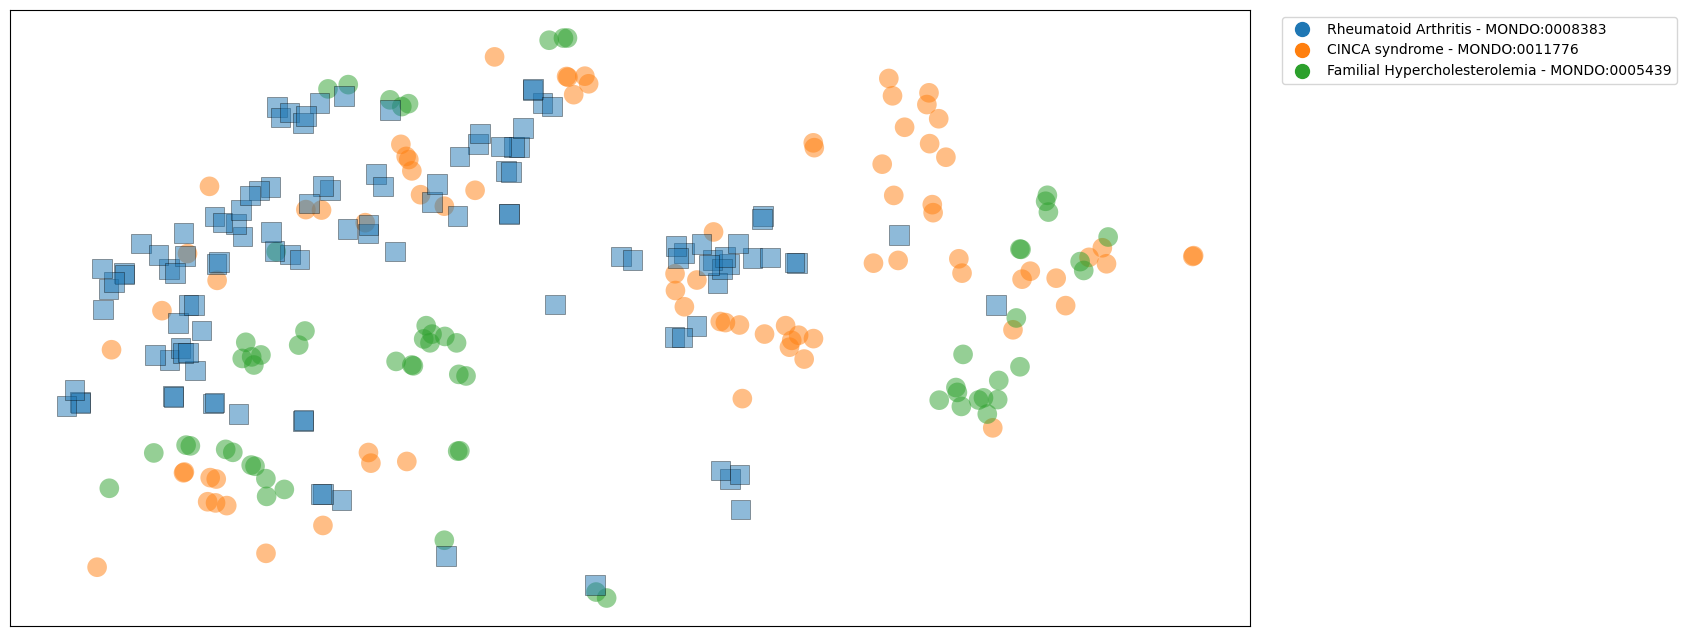

In [15]:
map_names = [PRIMARY_DISEASE, 'CINCA syndrome - MONDO:0011776', 'Familial Hypercholesterolemia - MONDO:0005439']
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names)]),
    cmap="tab10",
    draw_edges=False,
    draw_node_labels=False,
    figsize=(16, 8),
    dpi=100,
    bbox_to_anchor=(1.35, 1)
)

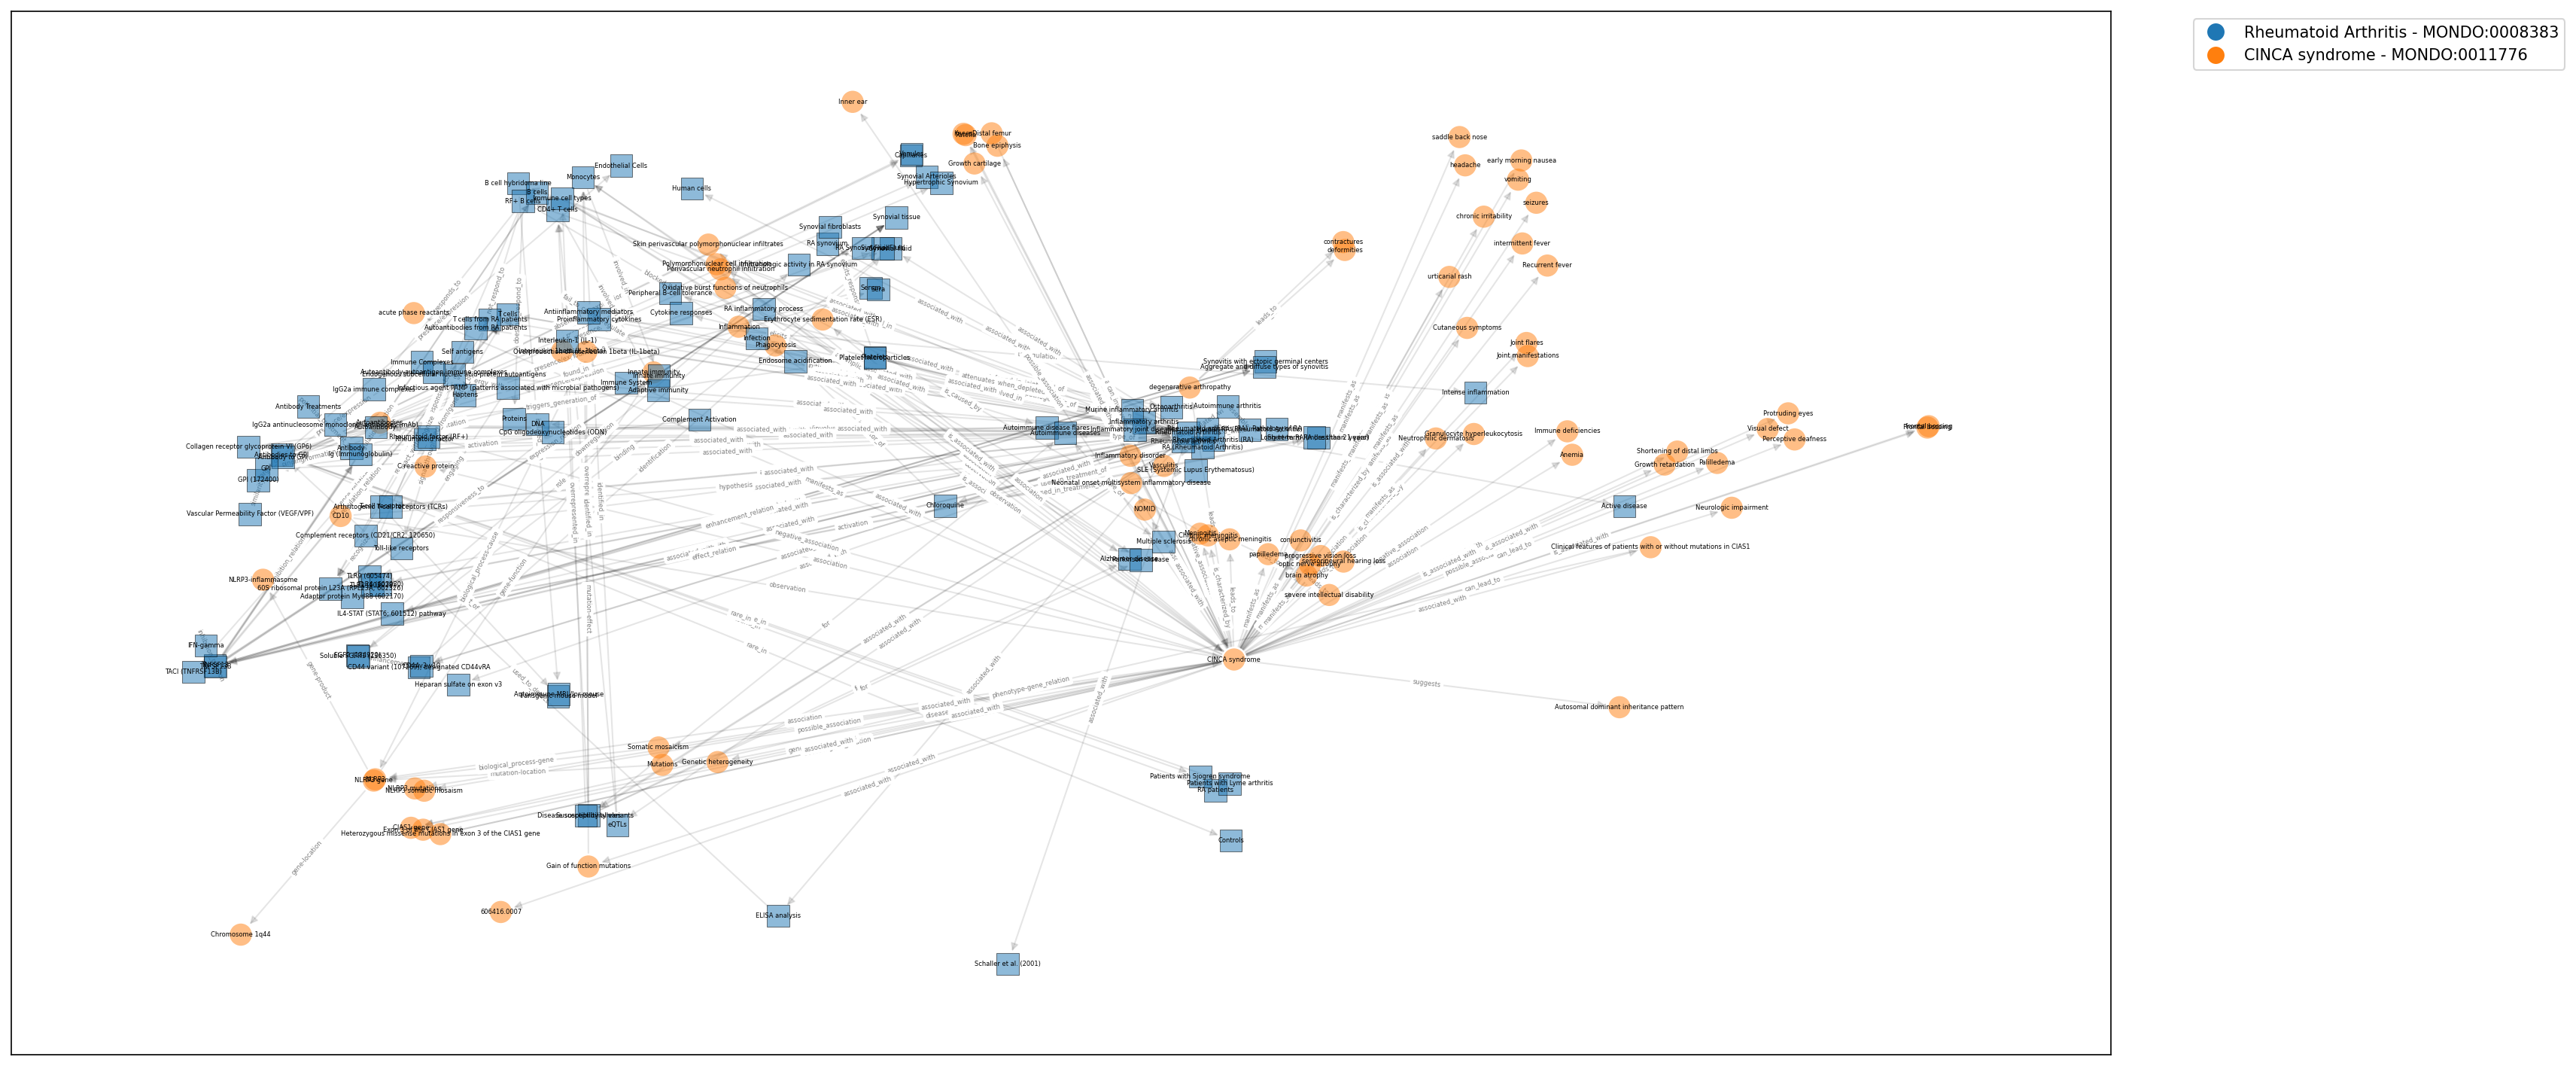

In [16]:
map_names = ['CINCA syndrome - MONDO:0011776', 'Rheumatoid Arthritis - MONDO:0008383']
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names)]),
    cmap="tab10"
)

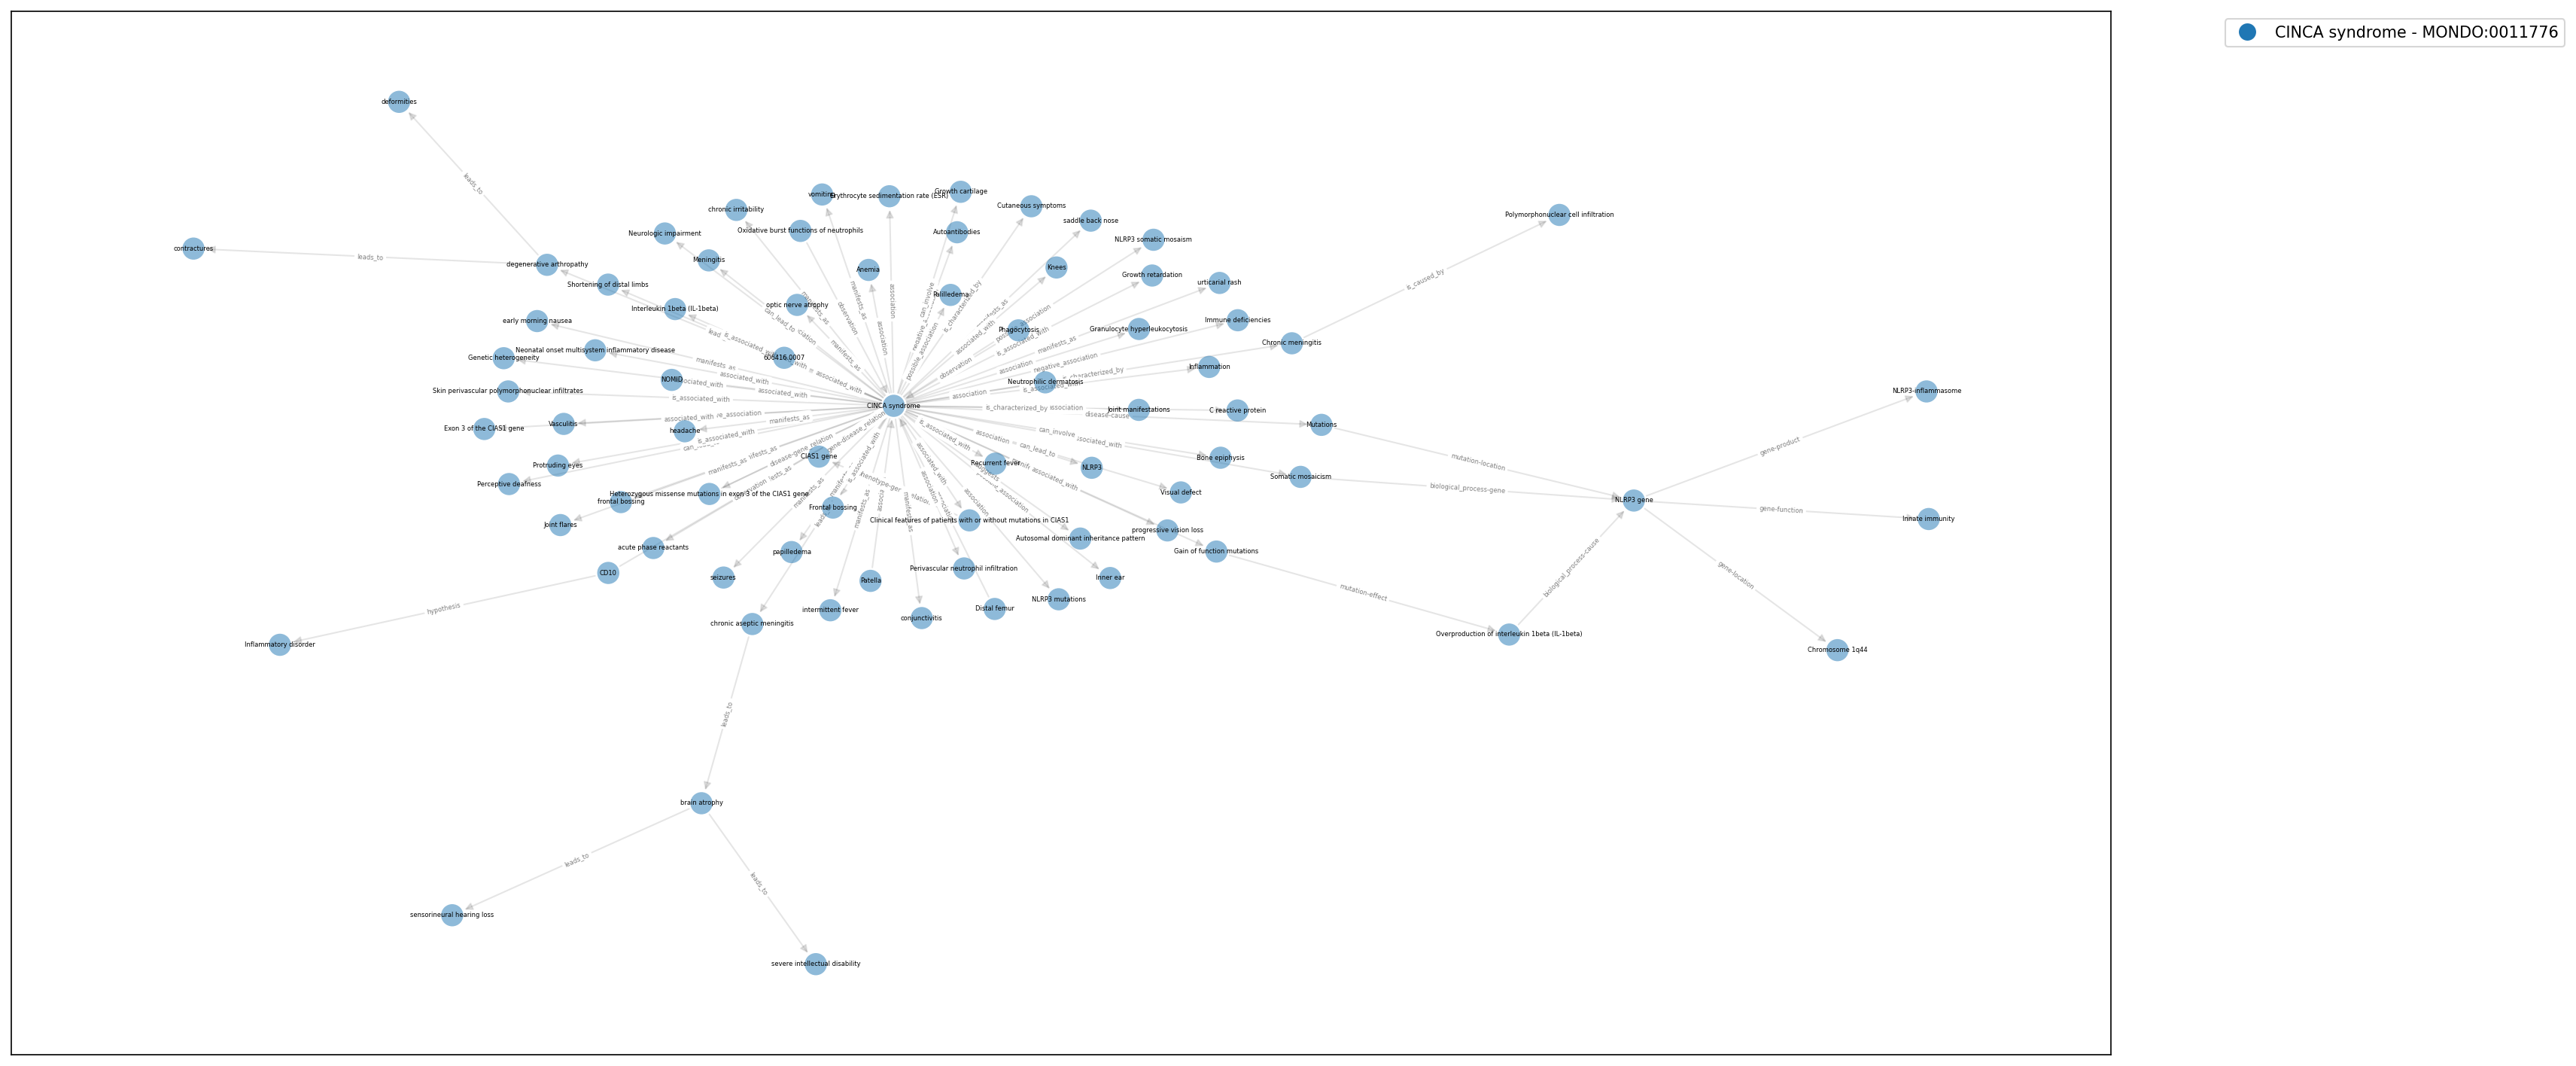

In [17]:
map_names = ['CINCA syndrome - MONDO:0011776']
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names)]),
    cmap="tab10",
    position="graphviz"
)

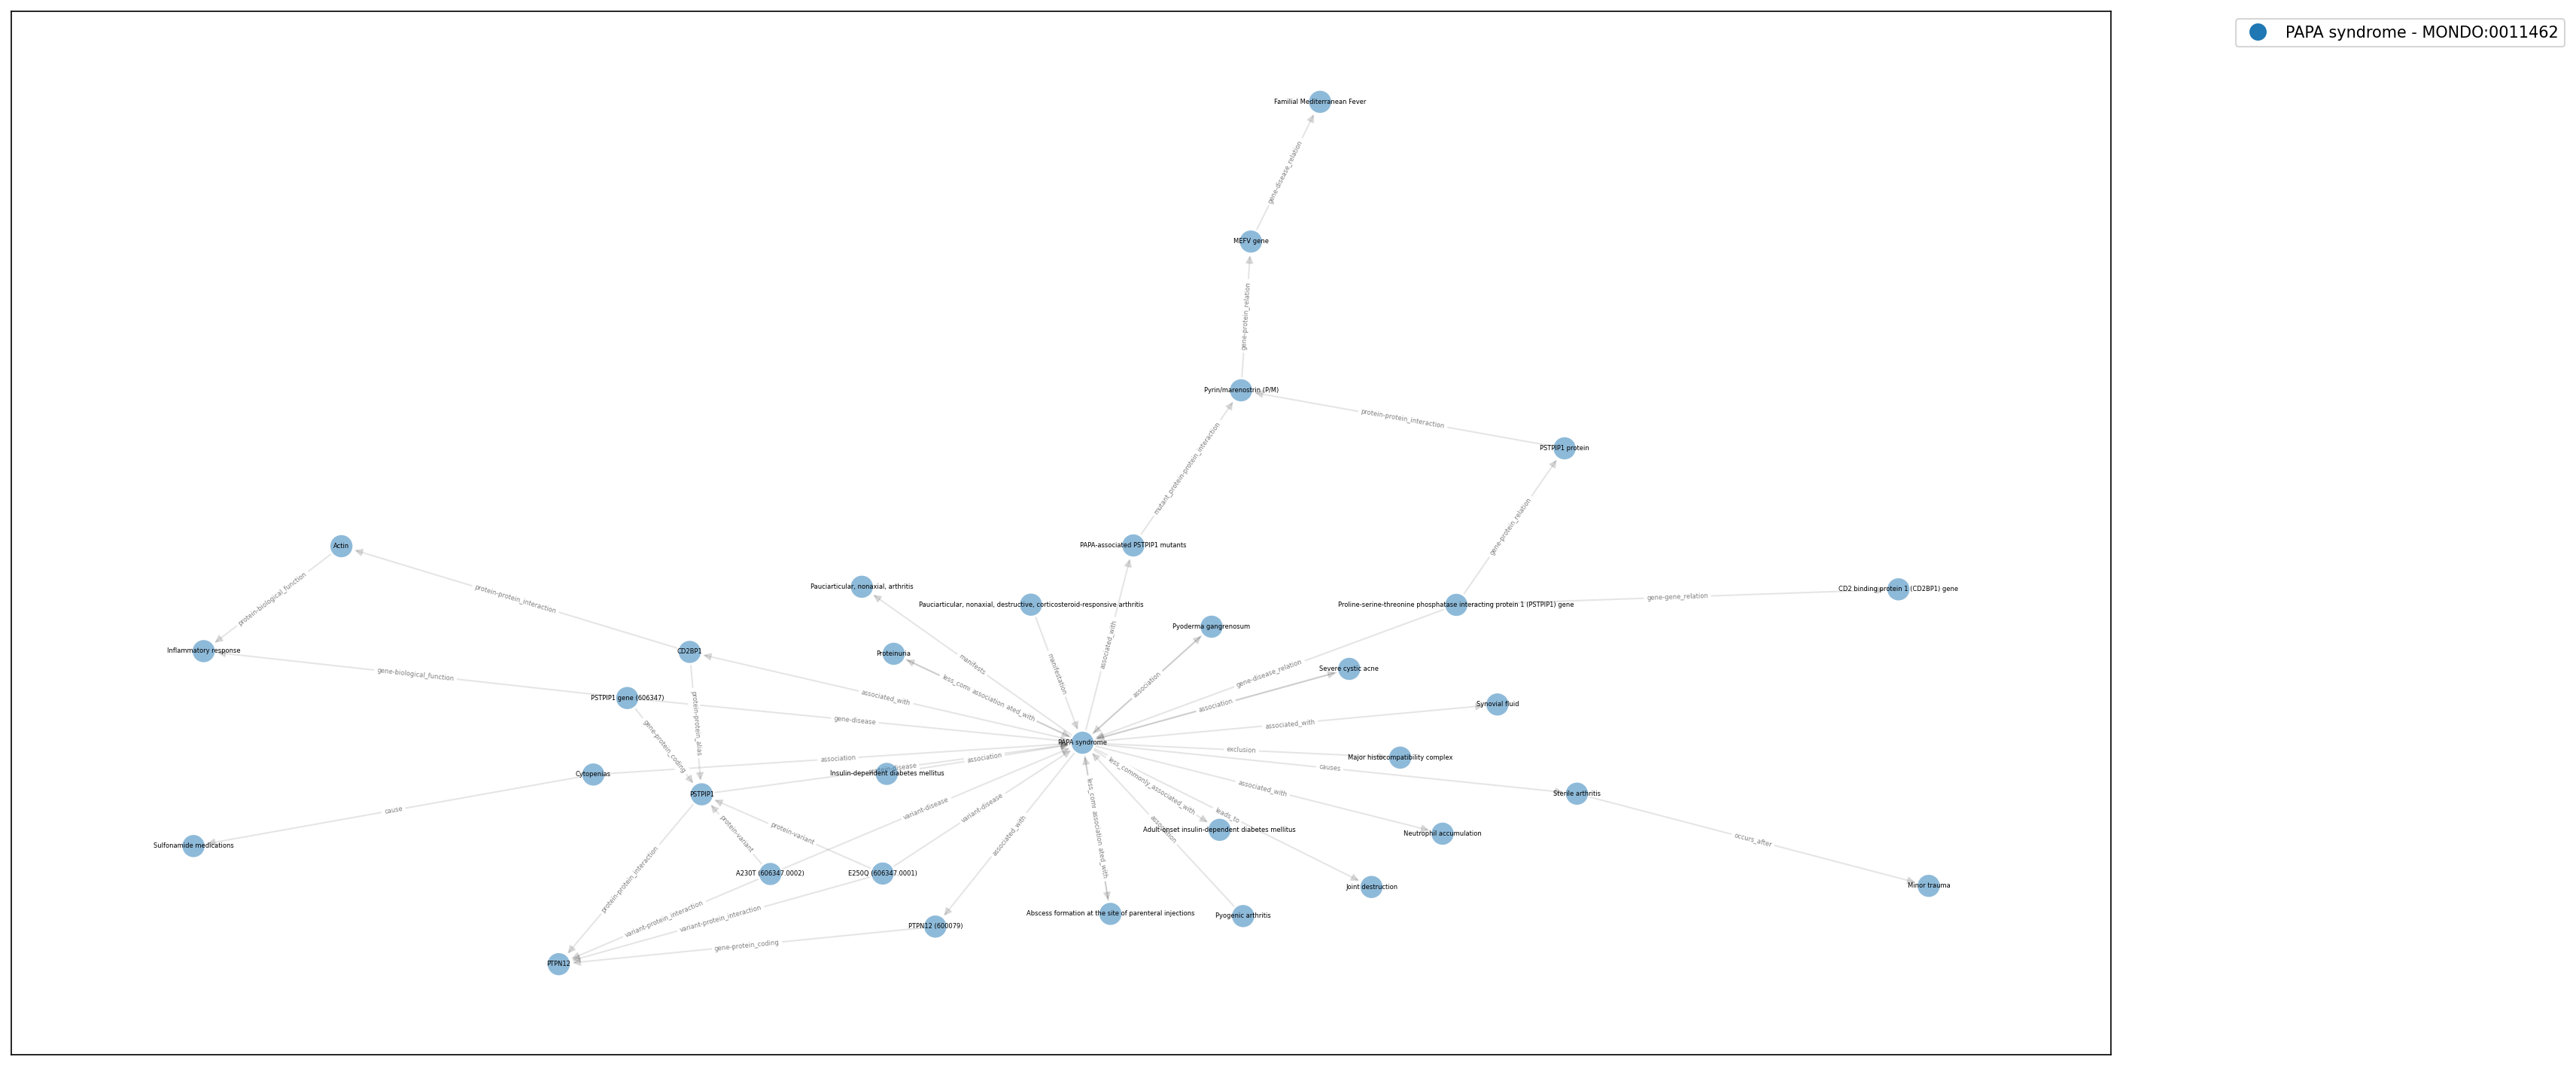

In [54]:
map_names = ['PAPA syndrome - MONDO:0011462']
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names)]),
    cmap="tab10",
    position="graphviz"
)

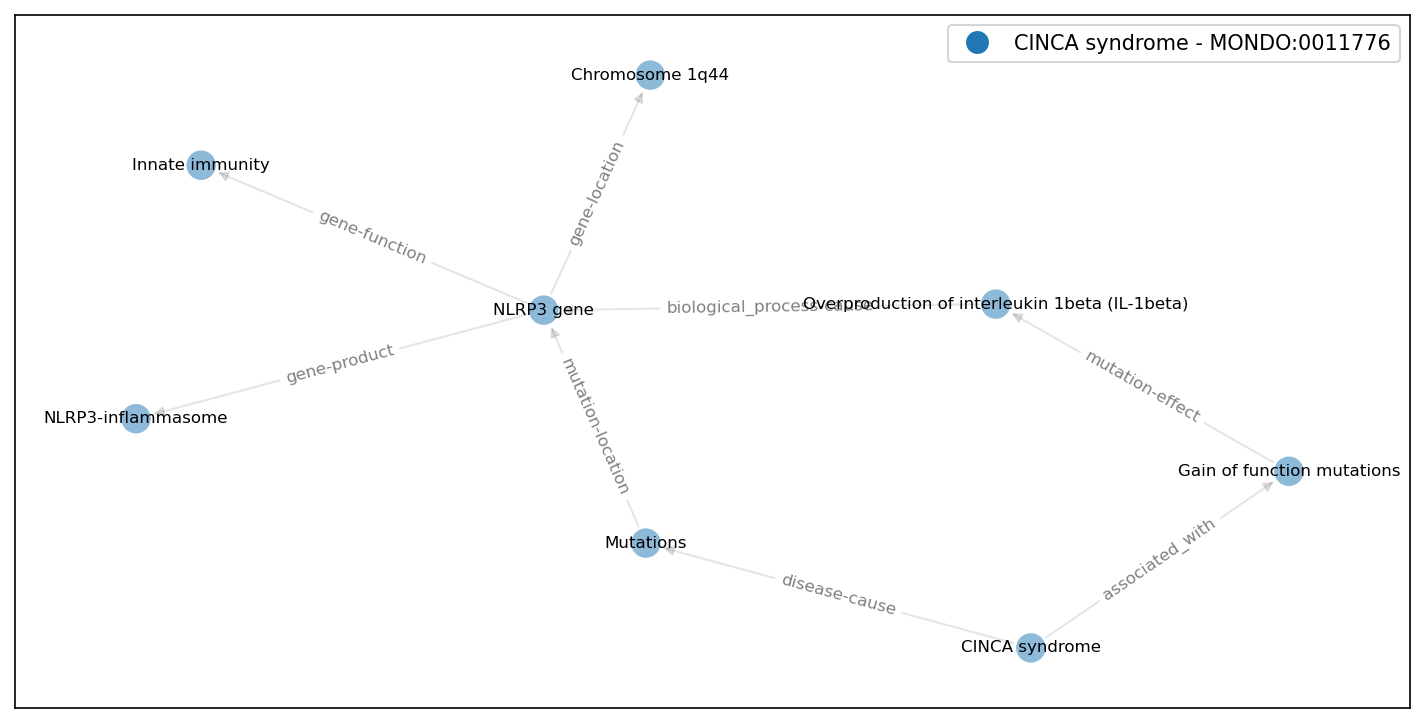

In [18]:
map_names = ['CINCA syndrome - MONDO:0011776']
cinca_nodes = {
    n
    for target, path in nx.single_source_shortest_path(
        nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]),
        'MONDO:0011776-CINCA syndrome'
    ).items()
    for n in path
    if 'MONDO:0011776-NLRP3 gene' in path or 'MONDO:0011776-Gain of function mutations' in path
}
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if n in cinca_nodes]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names) & df['id'].isin(cinca_nodes)]),
    cmap="tab10",
    position="graphviz",
    figsize=(12, 6),
    font_size=8,
    bbox_to_anchor=(1, 1)
)

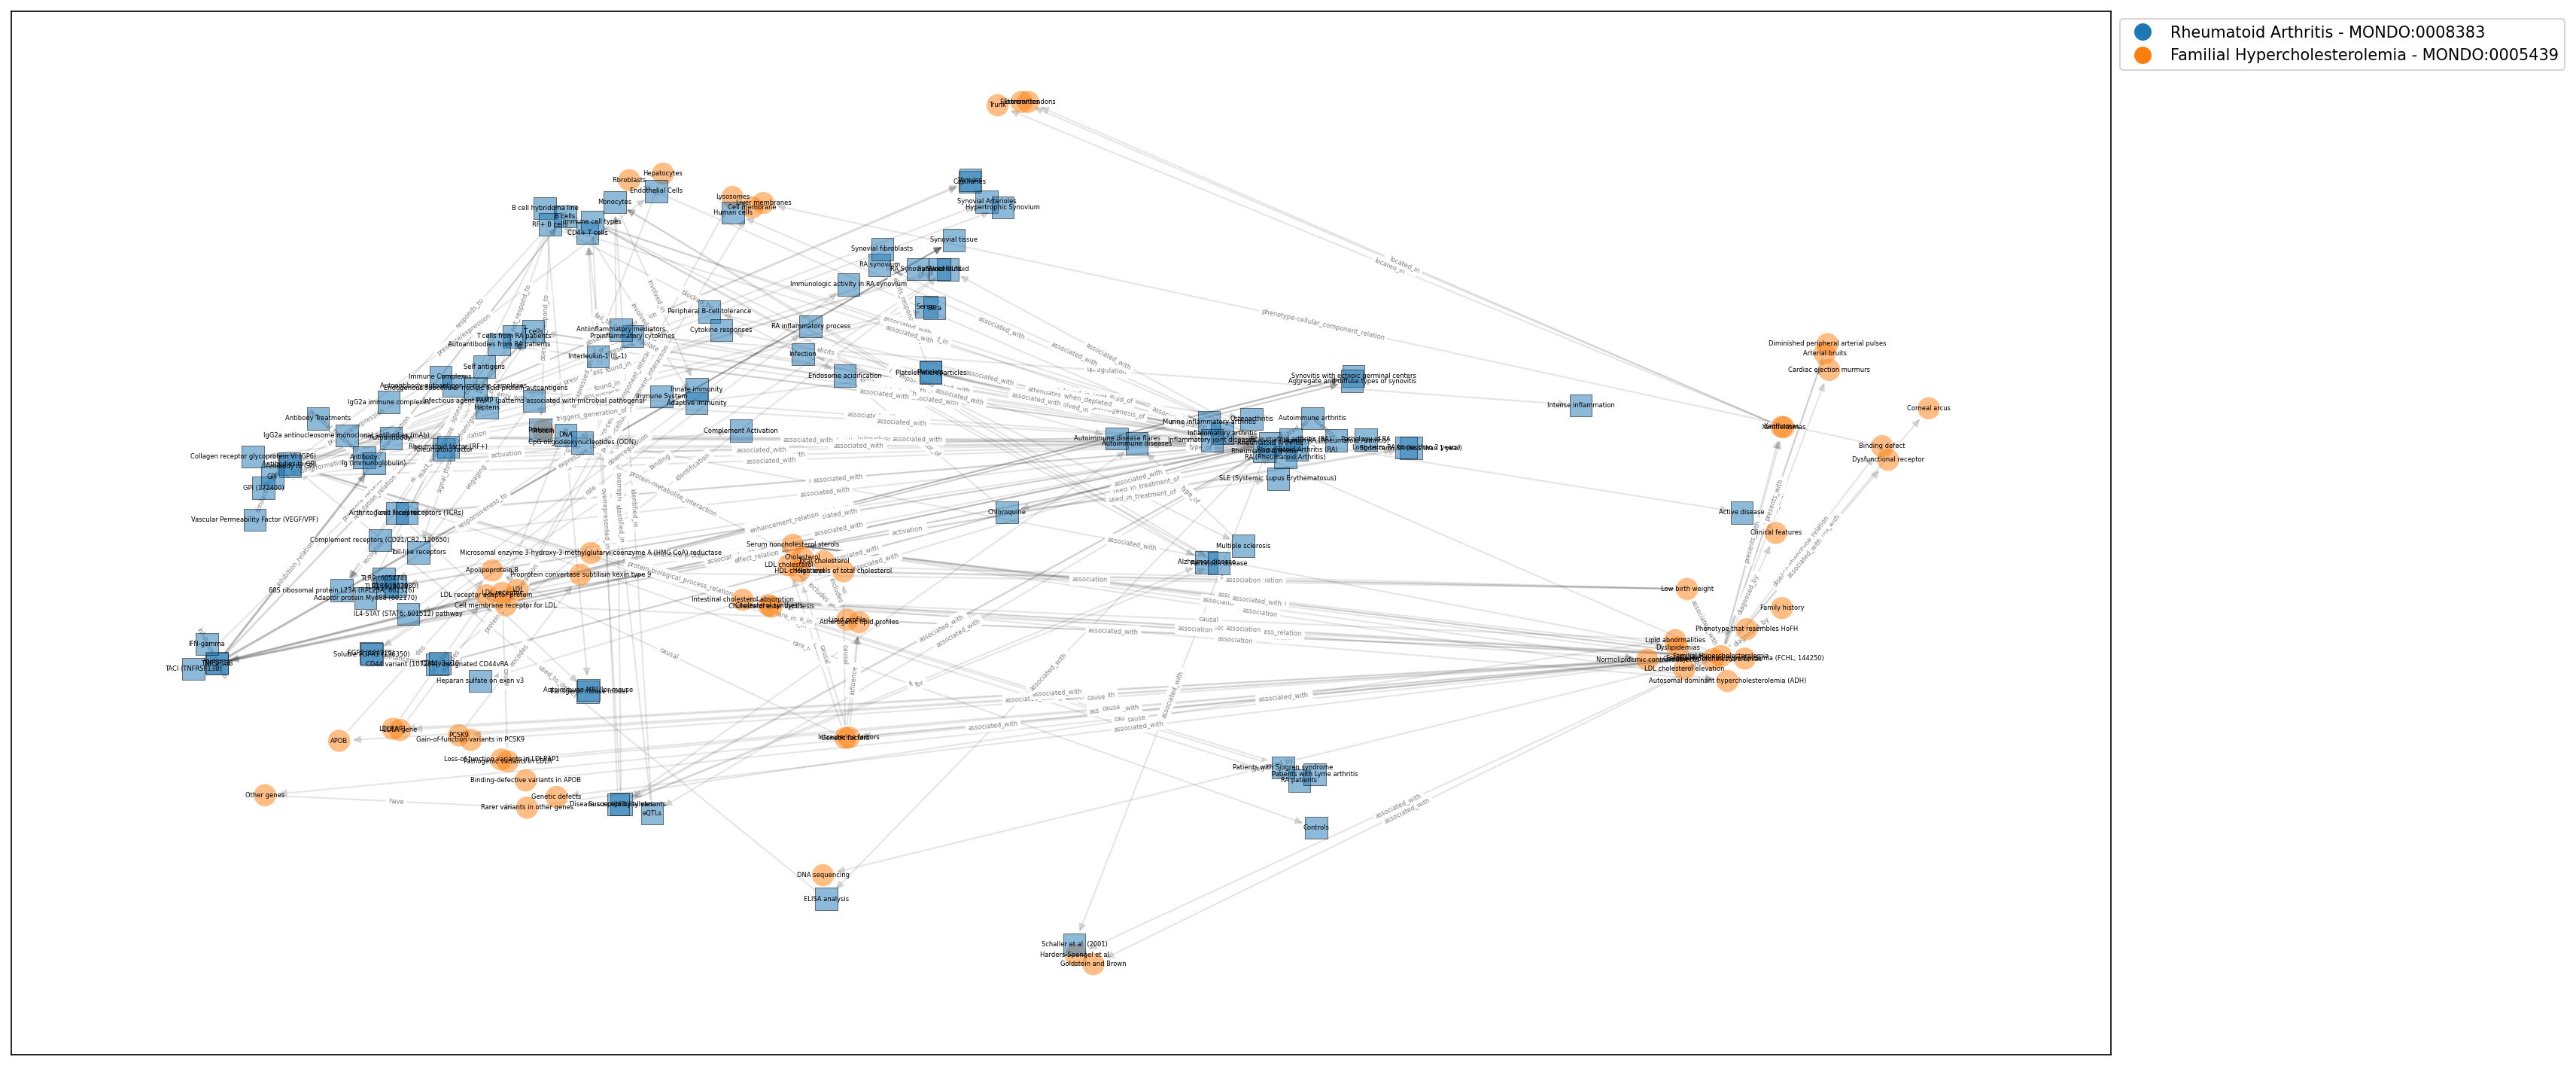

In [19]:
map_names = ['Familial Hypercholesterolemia - MONDO:0005439', 'Rheumatoid Arthritis - MONDO:0008383']
plot_map(
    nx.subgraph(graph, [n for n, d in graph.nodes(data=True) if d['map_name'] in map_names]), 
    node_info.pipe(lambda df: df[df['map_name'].isin(map_names)]),
    cmap="tab10"
)

In [50]:
SIMILARITY_THRESOLD = .88

def get_shared_mechanisms(disease1, disease2, nodes, show_rows=False, threshold=SIMILARITY_THRESOLD):
    return (
        nodes
        .pipe(lambda df: pd.DataFrame([
            dict(similarity=1 - spatial.distance.cosine(r1.embedding, r2.embedding), d1_id=f"{r1.type}: {r1.label}", d2_id=f"{r2.type}: {r2.label}")
            for r1 in df[df['map_name'] == disease1].itertuples()
            for r2 in df[df['map_name'] == disease2].itertuples()
        ]))
        .pipe(utils.apply, lambda df: display(df.sort_values('similarity', ascending=False).head(50)) if show_rows else None)
        .pipe(lambda df: df[df['similarity'] >= threshold])
        .set_index(['d1_id', 'd2_id'])['similarity']
        .unstack()    
        .rename_axis(disease1, axis='index')
        .rename_axis(disease2, axis='columns')
    )

def plot_shared_mechanisms(df, threshold=SIMILARITY_THRESOLD):
    g = sns.clustermap(
        df.fillna(0), cmap="viridis", figsize=(16, 12), 
        yticklabels=1, xticklabels=1, 
        vmin=threshold, 
        vmax=1, dendrogram_ratio=.2,
        cbar_kws={'label': 'embedding similarity'}
    )
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=25, horizontalalignment='right')
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    g.fig.suptitle('Putative disease mechanism intersection') 

similarity  \
7926    0.997949   
3353    0.987232   
7847    0.948819   
7377    0.926973   
5503    0.924655   
3195    0.924245   
7656    0.921807   
6214    0.920665   
1178    0.920486   
1772    0.917035   
5407    0.910862   
1773    0.906243   
6154    0.906104   
5520    0.904152   
1019    0.901742   
3107    0.901359   
9120    0.900258   
7376    0.899289   
8288    0.898942   
5170    0.898675   
941     0.895754   
8209    0.893752   
3589    0.893626   
5128    0.893417   
8335    0.892866   
8172    0.892095   
8255    0.891565   
5473    0.891360   
3352    0.890677   
7129    0.890541   
8344    0.889769   
7498    0.889222   
1378    0.888280   
366     0.886844   
364     0.886151   
367     0.885454   
6508    0.884969   
3864    0.884708   
3231    0.884684   
908     0.884454   
3831    0.884436   
5760    0.884343   
5095    0.884247   
3590    0.883567   
7241    0.883309   
72      0.883156   
3447    0.882375   
1694    0.882171   
3194    0.882088   
8804    0.881658   

                                                                              d1_id  \
7926                                           Biological Function: Innate immunity   
3353                                                          Protein: Autoantibody   
7847                                         Biological Function: Adaptive immunity   
7377                                      Biological Entities: Interleukin-1 (IL-1)   
5503                                                  Biological process: Infection   
3195                                                              Protein: Antibody   
7656                               Diseases/Conditions: Inflammatory joint diseases   
6214                                    Biological Process: RA inflammatory process   
1178                                    Diseases/Conditions: Inflammatory arthritis   
1772                                                     Protein: Rheumatoid factor   
5407                 Biological molecule: Autoantibody-autoantigen immune complexes   
1773                                                     Protein: Rheumatoid factor   
6154                                                       Protein/Gene: CD44v3-v10   
5520                                                  Biological process: Infection   
1019                                                       Protein: T-cell receptor   
3107                                               Biological System: Immune System   
9120                             Biological entity: Autoantibodies from RA patients   
7376                                      Biological Entities: Interleukin-1 (IL-1)   
8288                                                  Disease: Rheumatoid arthritis   
5170  Biological molecule: Endogenous subcellular nucleic acid-protein autoantigens   
941                                                   Disease: Rheumatoid Arthritis   
8209                                                   Disease: Autoimmune diseases   
3589                                               Protein: Rheumatoid factor (RF+)   
5128                                             Disease: RA (Rheumatoid Arthritis)   
8335                                                    Disease: Multiple sclerosis   
8172                                                   Disease: Autoimmune diseases   
8255                                                  Disease: Rheumatoid arthritis   
5473                                                  Biological process: Infection   
3352                                                          Protein: Autoantibody   
7129                                            Diseases/Conditions: Osteoarthritis   
8344                                                    Disease: Multiple sclerosis   
7498                             Diseases/Conditions: Murine inflammatory arthritis   
1378                                                     Protein: Antibodies to GPI   
366                        

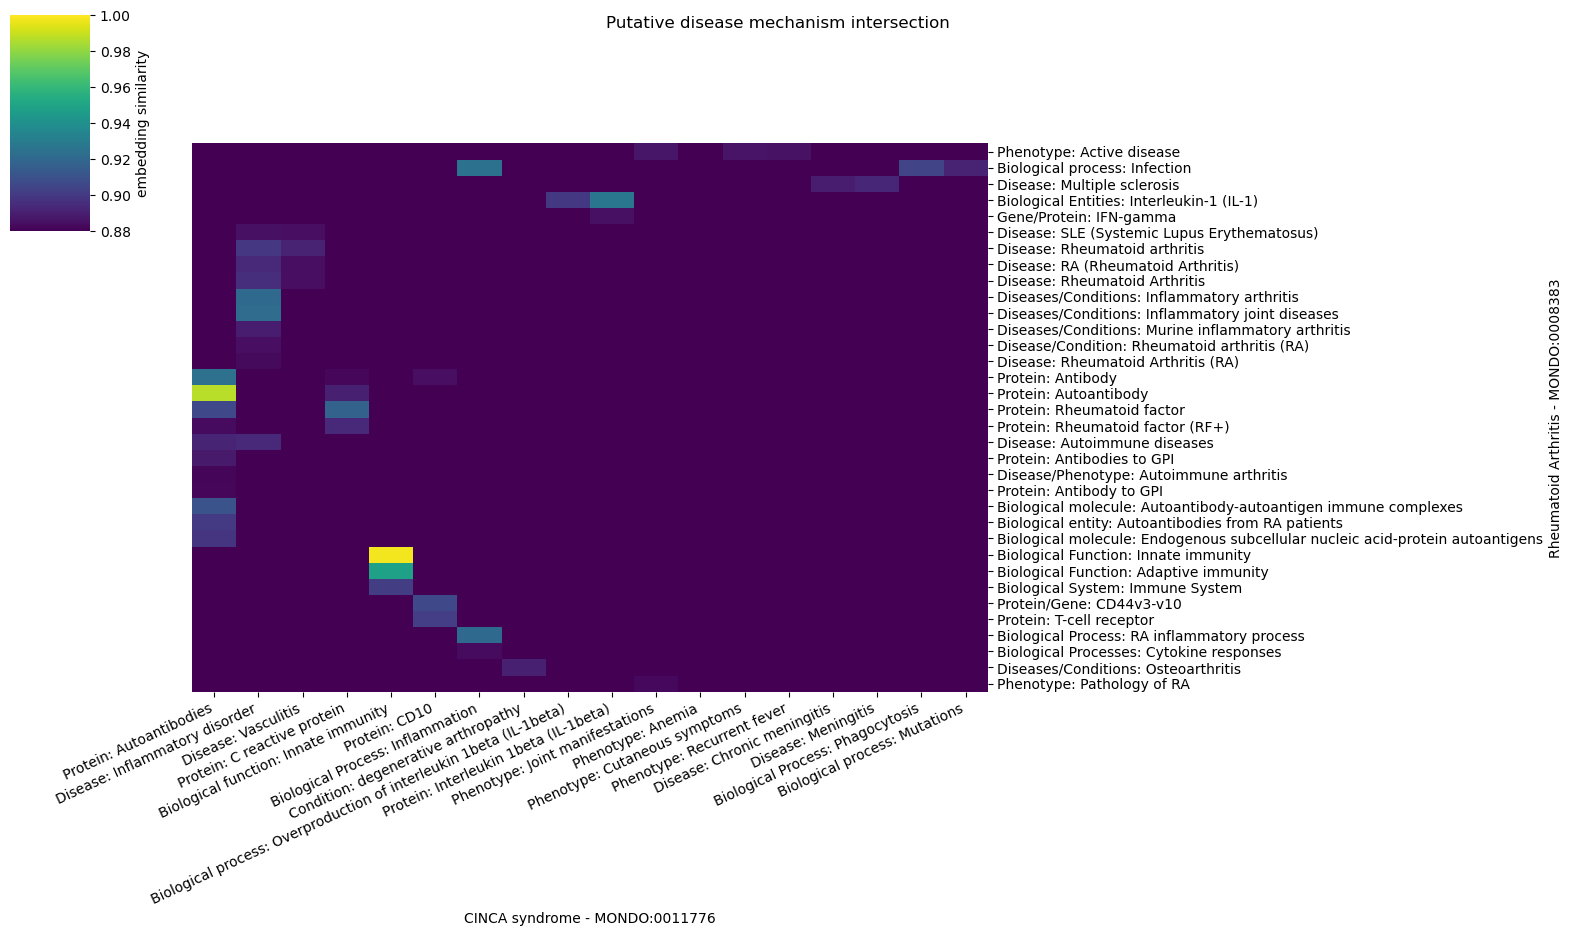

In [21]:
(
    get_shared_mechanisms(PRIMARY_DISEASE, 'CINCA syndrome - MONDO:0011776', node_info, show_rows=True)
    .pipe(plot_shared_mechanisms)
);

similarity                                                     d1_id  \
107     0.975279                          Biological Fluid: Synovial fluid   
1025    0.972392                          Biological Fluid: Synovial Fluid   
1093    0.945116                       Biological Fluid: RA Synovial Fluid   
3433    0.914973                      Biological Function: Innate immunity   
439     0.907127                                  Protein: T-cell receptor   
3781    0.906792                   Disease/Phenotype: Autoimmune arthritis   
3399    0.906463                    Biological Function: Adaptive immunity   
3793    0.904528                   Disease/Phenotype: Autoimmune arthritis   
2895    0.900366                              Tissue Type: Synovial tissue   
3775    0.898512                   Disease/Phenotype: Autoimmune arthritis   
1391    0.896310                                         Protein: Antibody   
432     0.895831                                  Protein: T-cell receptor   
787     0.894495                                   Biological fluid: Serum   
1833    0.894170          Protein: Complement receptors (CD21/CR2, 120650)   
3794    0.893715                   Disease/Phenotype: Autoimmune arthritis   
511     0.893672        Disease/Phenotype: Human RA (Rheumatoid Arthritis)   
189     0.892888                           Phenotype: Intense inflammation   
1392    0.888577                                         Protein: Antibody   
1481    0.887308                                Phenotype: Pathology of RA   
2649    0.885245                                  Protein/Gene: CD44v3-v10   
529     0.884472        Disease/Phenotype: Human RA (Rheumatoid Arthritis)   
73      0.884411                          Biological entities: RA synovium   
3133    0.883147                 Biological Entities: Synovial fibroblasts   
991     0.881632                                    Biological Fluid: Sera   
978     0.881142                                              Protein: GPI   
373     0.881078  Biological function: Immunologic activity in RA synovium   
2853    0.880867                              Protein: Ig (Immunoglobulin)   
1459    0.880133                                     Protein: Autoantibody   
155     0.879586                                 Phenotype: Active disease   
745     0.879145                                  Protein: Antibody to GPI   
67      0.878015            Biological entities: Proinflammatory cytokines   
2747    0.877652                                    Gene/Protein: TNFSF13B   
530     0.877493        Disease/Phenotype: Human RA (Rheumatoid Arthritis)   
2713    0.876656                                     Gene/Protein: TNFSF13   
178     0.876554                           Phenotype: Intense inflammation   
1463    0.876444                                Phenotype: Pathology of RA   
983     0.876308                                              Protein: GPI   
1384    0.876049                                         Protein: Antibody   
3537    0.875545                             Disease: Rheumatoid arthritis   
172     0.874993                           Phenotype: Intense inflammation   
2631    0.874110                                  Protein/Gene: CD44v3-v10   
2846    0.873425                              Protein: Ig (Immunoglobulin)   
177     0.873229                           Phenotype: Intense inflammation   
375     0.872404                             Disease: Rheumatoid Arthritis   
3764    0.872244            Protein: Arthritogenic T-cell receptors (TCRs)   
966     0.872242                                              Protein: GPI   
1867    0.872004                   Protein: Adaptor protein Myd88 (602170)   
158     0.871420                                 Phenotype: Active disease   
237     0.870824           Biological entities: Antiinflammatory mediators   
2427    0.869983   Protein/Gene: CD44 variant (107269), designated CD44vRA   

                           

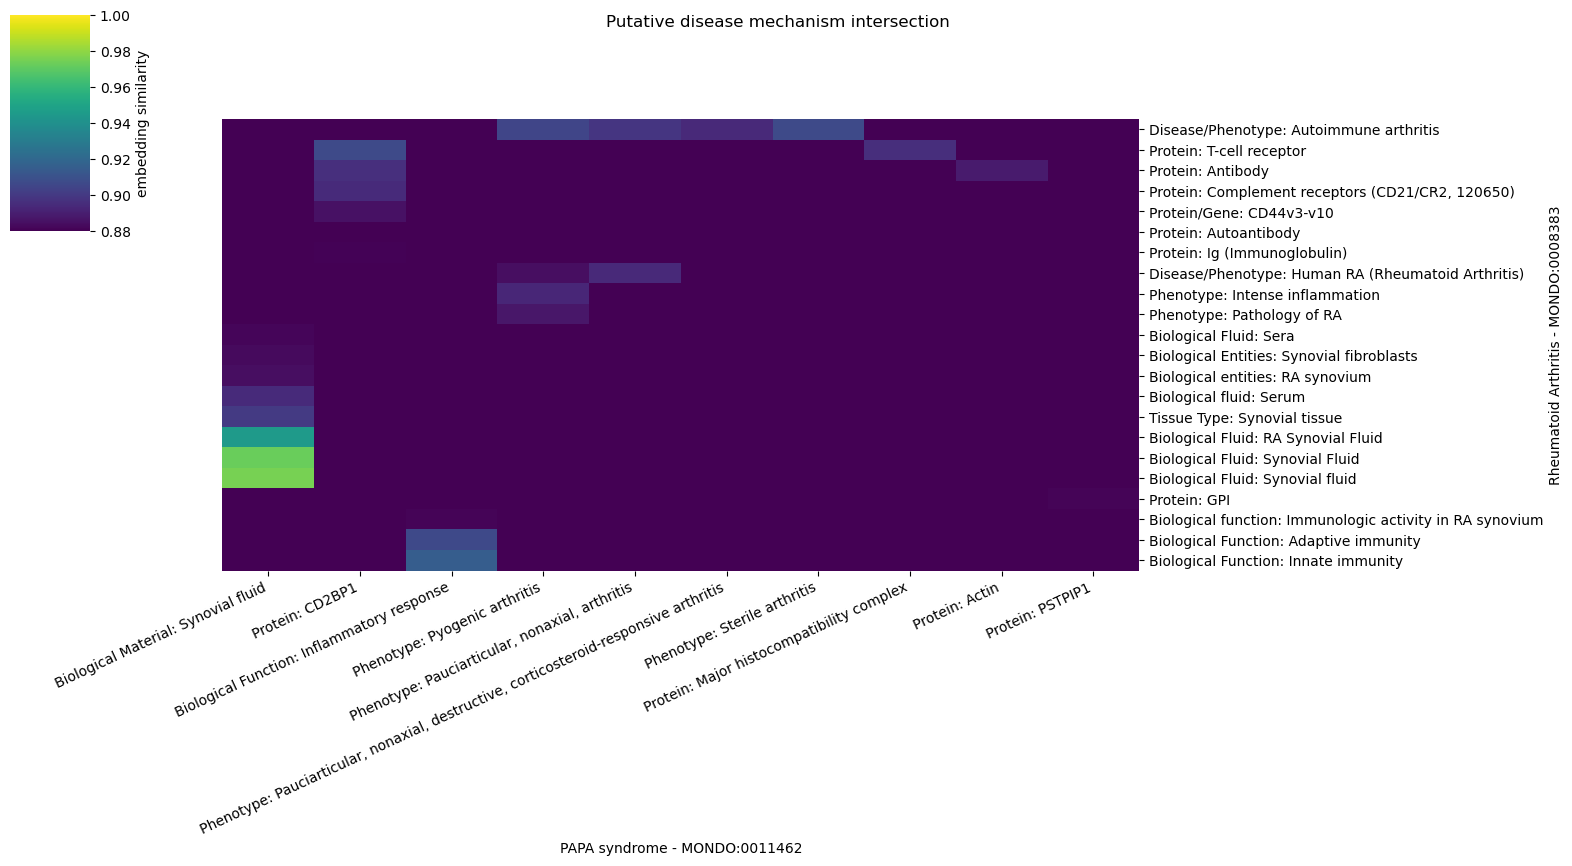

In [22]:
(
    get_shared_mechanisms(PRIMARY_DISEASE, 'PAPA syndrome - MONDO:0011462', node_info, show_rows=True)
    .pipe(plot_shared_mechanisms)
);

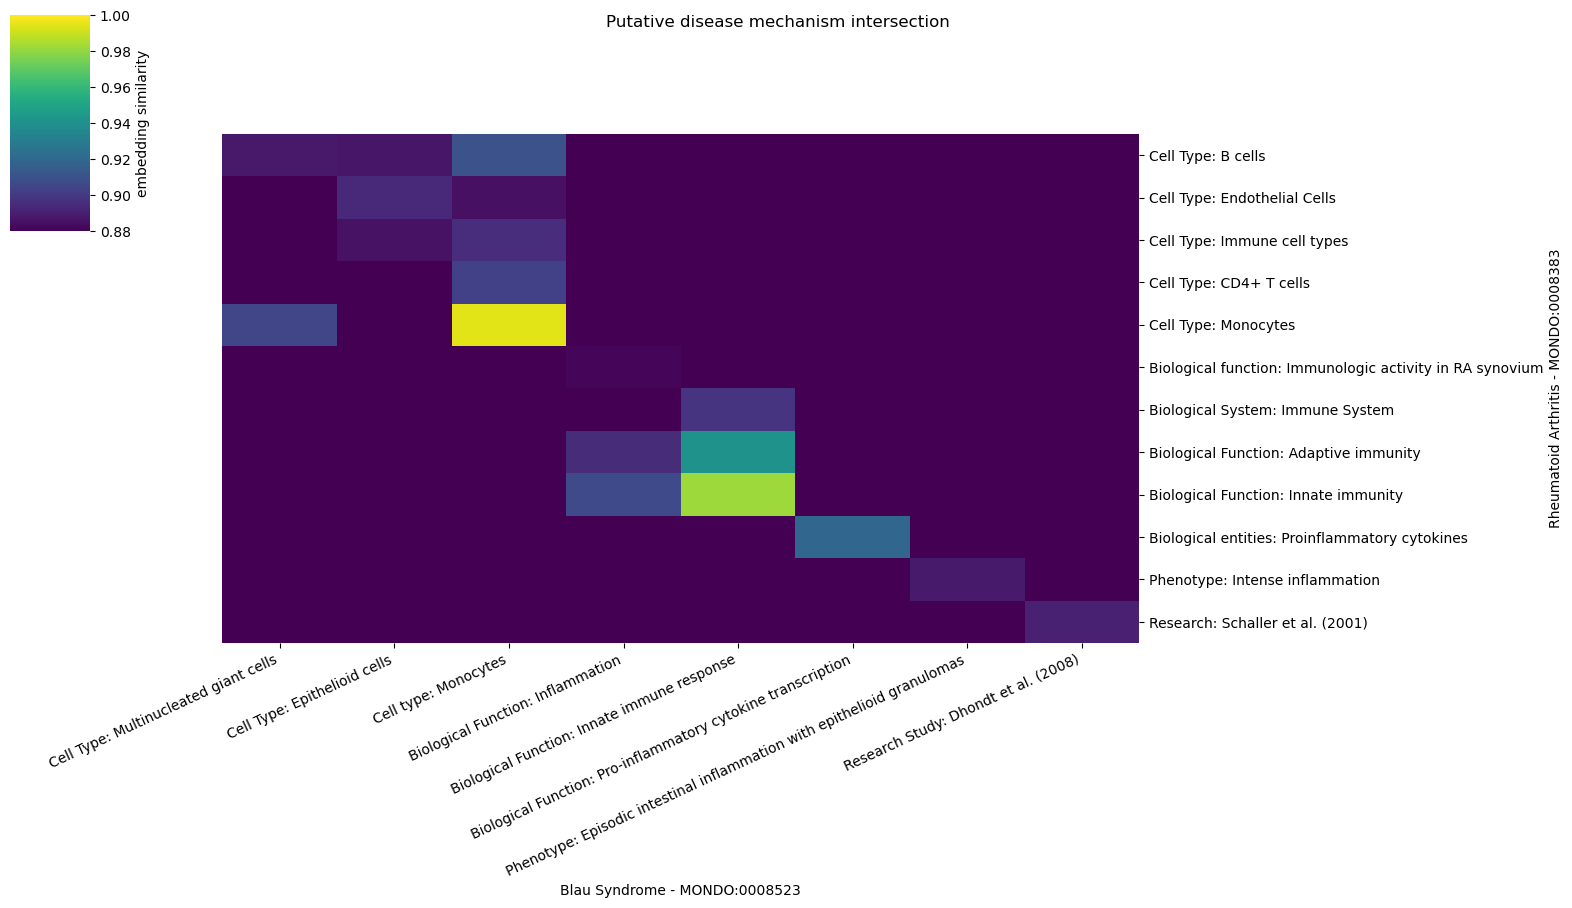

In [23]:
(
    get_shared_mechanisms(PRIMARY_DISEASE, 'Blau Syndrome - MONDO:0008523', node_info)
    .pipe(plot_shared_mechanisms)
);

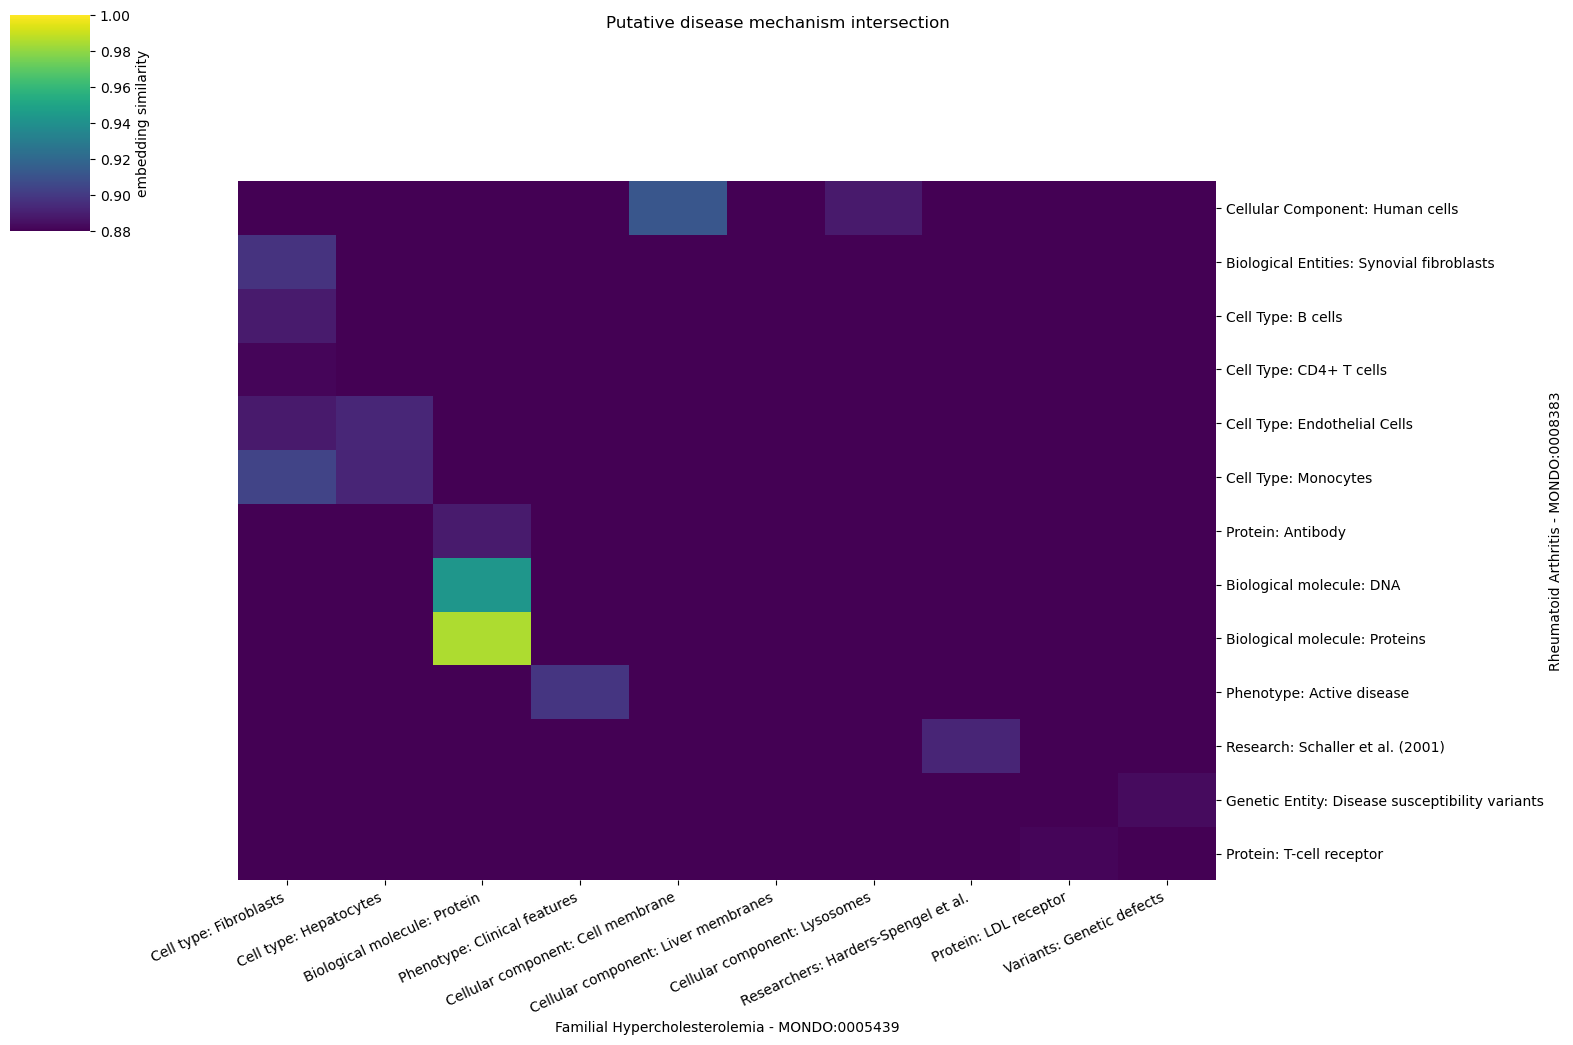

In [24]:
(
    get_shared_mechanisms(PRIMARY_DISEASE, 'Familial Hypercholesterolemia - MONDO:0005439', node_info)
    .pipe(plot_shared_mechanisms)
);